<a href="https://colab.research.google.com/github/Lee-1997/fuzzy-tribble/blob/master/gfootball_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get update
!apt-get install libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.0.6 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.0.6.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

DQN\
游戏环境是academy_empty_goal的simple115模式，代码中采用了普通的DQN算法，神经网络采用了11层的全连接网络，中间包含四个shortcuts，target net的参数每隔100步更新成current net的值。epsilon表示选取随机策略的概率，在初始时设置为1，随着step的增加线性递减直到0。训练结束的条件是过去50场游戏的平均reward>0.95。在训练时为了加快收敛的速度，只保留了4个actions，包括action_top、action_shot、action_dribble、action_release_dribble，禁用了剩余15个actions。最后output中的四张图分别为整个训练过程中每一场游戏的reward，训练过程中连续20场游戏的平均reward，训练过程中epsilon的变化，训练过程中loss的变化。可以看出训练结束时模型已经可以给出连续20场都进球的策略，模型见DQN_model.pkl。

Done no.1 game in 70 steps, mean reward of all games 1.000, mean reward of last 50 games 1.000, epsilon 0.993
Done no.2 game in 75 steps, mean reward of all games 1.000, mean reward of last 50 games 1.000, epsilon 0.986
Done no.3 game in 76 steps, mean reward of all games 0.667, mean reward of last 50 games 0.667, epsilon 0.978
Done no.4 game in 89 steps, mean reward of all games 0.750, mean reward of last 50 games 0.750, epsilon 0.969
Done no.5 game in 68 steps, mean reward of all games 0.600, mean reward of last 50 games 0.600, epsilon 0.962
Done no.6 game in 64 steps, mean reward of all games 0.667, mean reward of last 50 games 0.667, epsilon 0.956
Done no.7 game in 85 steps, mean reward of all games 0.714, mean reward of last 50 games 0.714, epsilon 0.947
Done no.8 game in 71 steps, mean reward of all games 0.625, mean reward of last 50 games 0.625, epsilon 0.940
Done no.9 game in 78 steps, mean reward of all games 0.667, mean reward of last 50 games 0.667, epsilon 0.932
Done no.10

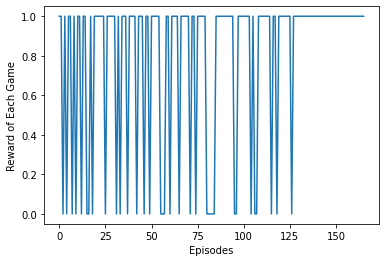

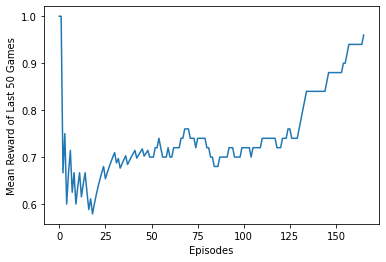

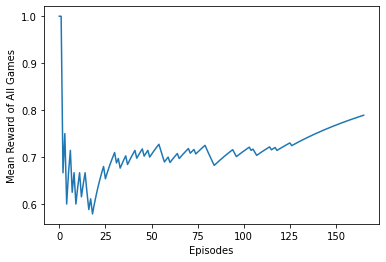

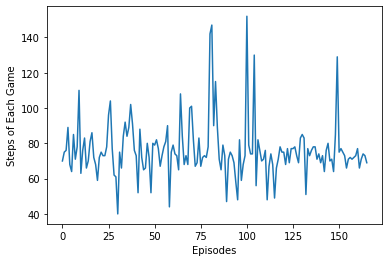

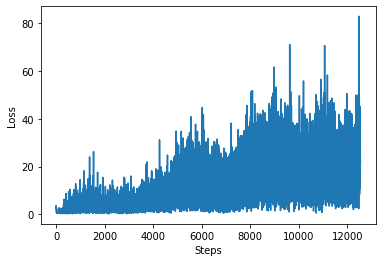

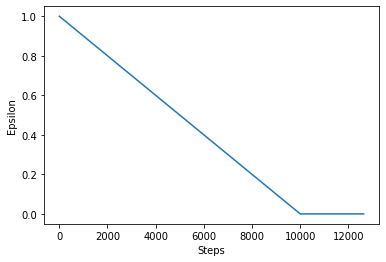

In [0]:
import numpy as np
import collections
import gfootball.env as football_env
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

MEAN_REWARD_BOUND = 0.95

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 1000
REPLAY_START_SIZE = 100
LEARNING_RATE = 1e-3
TARGET_COPY_STEPS = 100
EPSILON_DECAY_LAST_STEP = 10000
EPSILON_START = 1.0
EPSILON_FINAL = 0.

torch.manual_seed(0)
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class DQN(nn.Module):
  def __init__(self, input_size, output_size, embedding_size=100, hidden_size=20):
    super(DQN, self).__init__()
    self.fc1 = nn.Linear(input_size, embedding_size)
    self.bn1 = nn.BatchNorm1d(embedding_size)
    self.fc2 = nn.Linear(embedding_size, hidden_size)
    self.bn2 = nn.BatchNorm1d(hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.bn3 = nn.BatchNorm1d(hidden_size)
    self.fc4 = nn.Linear(hidden_size, hidden_size)
    self.bn4 = nn.BatchNorm1d(hidden_size)
    self.fc5 = nn.Linear(hidden_size, hidden_size)
    self.bn5 = nn.BatchNorm1d(hidden_size)
    self.fc6 = nn.Linear(hidden_size, hidden_size)
    self.bn6 = nn.BatchNorm1d(hidden_size)
    self.fc7 = nn.Linear(hidden_size, hidden_size)
    self.bn7 = nn.BatchNorm1d(hidden_size)
    self.fc8 = nn.Linear(hidden_size, hidden_size)
    self.bn8 = nn.BatchNorm1d(hidden_size)
    self.fc9 = nn.Linear(hidden_size, hidden_size)
    self.bn9 = nn.BatchNorm1d(hidden_size)
    self.fc10 = nn.Linear(hidden_size, hidden_size)
    self.bn10 = nn.BatchNorm1d(hidden_size)
    self.fc11 = nn.Linear(hidden_size, output_size)    

  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = F.relu(x + self.bn4(self.fc4(F.relu(self.bn3(self.fc3(x))))))
    x = F.relu(x + self.bn6(self.fc6(F.relu(self.bn5(self.fc5(x))))))
    x = F.relu(x + self.bn8(self.fc8(F.relu(self.bn7(self.fc7(x))))))
    x = F.relu(x + self.bn10(self.fc10(F.relu(self.bn9(self.fc9(x))))))
    x = self.fc11(x)
    return x

class ExperienceBuffer:
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    indices = np.random.choice(len(self.buffer), batch_size, replace=False)
    states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
    return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.uint8), np.array(next_states)


class Agent:
  def __init__(self, env, exp_buffer):
    self.env = env
    self.exp_buffer = exp_buffer
    self._reset()

  def _reset(self):
    self.state = env.reset()
    self.total_reward = 0.0

  def play_step(self, net, epsilon=0.0, device="cpu"):
    done_reward = None
    while True:
      if np.random.random() < epsilon:
        action = env.action_space.sample()
      else:
        net.eval()
        state_a = np.array([self.state], copy=False)
        state_v = torch.tensor(state_a).to(device)
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
      if action not in [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]:
        break
    
    new_state, reward, is_done, _ = self.env.step(action)
    self.total_reward += reward
    exp = Experience(self.state, action, reward, is_done, new_state)
    self.exp_buffer.append(exp)
    self.state = new_state
    if is_done:
      done_reward = self.total_reward
      self._reset()
    return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
  states, actions, rewards, dones, next_states = batch
  states_v = torch.tensor(states).to(device)
  next_states_v = torch.tensor(next_states).to(device)
  actions_v = torch.tensor(actions).to(device)
  rewards_v = torch.tensor(rewards).to(device)
  done_mask = torch.ByteTensor(dones).to(device)
  state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
  next_state_values = tgt_net(next_states_v).max(1)[0]
  next_state_values[done_mask] = 0.0
  next_state_values = next_state_values.detach()
  expected_state_action_values = next_state_values * GAMMA + rewards_v
  return nn.MSELoss()(state_action_values, expected_state_action_values)


if __name__ == "__main__":
  # print(torch.cuda.is_available())
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  env = football_env.create_environment(env_name="academy_empty_goal", representation='simple115', 
                                        number_of_left_players_agent_controls=1, stacked=False, logdir='/tmp/football', 
                                        write_goal_dumps=False, write_full_episode_dumps=False, render=False)
  net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
  tgt_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
  buffer = ExperienceBuffer(REPLAY_SIZE)
  agent = Agent(env, buffer)
  epsilon = EPSILON_START
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
  total_rewards = []
  mean_rewards_50 = []
  mean_rewards = []
  game_steps = []
  Eps = []
  loss = []
  step_idx = 0
  last_game_step_idx = 0
  best_mean_reward = None

  while True:
    step_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - step_idx / EPSILON_DECAY_LAST_STEP)
    Eps.append(epsilon)
    reward = agent.play_step(net, epsilon, device=device)
    if reward is not None:
      total_rewards.append(reward)
      mean_reward_50 = np.mean(total_rewards[-50:])
      mean_reward = np.mean(total_rewards)
      mean_rewards_50.append(mean_reward_50)
      mean_rewards.append(mean_reward)
      game_steps.append(step_idx-last_game_step_idx)
      print("Done no.%d game in %d steps, mean reward of all games %.3f, mean reward of last 50 games %.3f, epsilon %.3f" 
            % (len(total_rewards), step_idx-last_game_step_idx, mean_reward, mean_reward_50, epsilon))
      last_game_step_idx = step_idx
      if best_mean_reward is None or best_mean_reward < mean_reward_50:
        torch.save(net, 'DQN_model.pkl')
        best_mean_reward = mean_reward_50
      if mean_reward_50 > MEAN_REWARD_BOUND and epsilon == EPSILON_FINAL:
        print("Solved in total %d steps!" % step_idx)
        break

    if len(buffer) < REPLAY_START_SIZE:
      continue

    if step_idx % TARGET_COPY_STEPS == 0:
      tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss.append(loss_t.item())
    loss_t.backward()
    optimizer.step()
    
  plt.plot(total_rewards)
  plt.ylabel('Reward of Each Game')
  plt.xlabel('Episodes')
  plt.show()
  plt.plot(mean_rewards_50)
  plt.ylabel('Mean Reward of Last 50 Games')
  plt.xlabel('Episodes')
  plt.show()
  plt.plot(mean_rewards)
  plt.ylabel('Mean Reward of All Games')
  plt.xlabel('Episodes')
  plt.show()
  plt.plot(game_steps)
  plt.ylabel('Steps of Each Game')
  plt.xlabel('Episodes')
  plt.show()
  plt.plot(loss)
  plt.ylabel('Loss')
  plt.xlabel('Steps')
  plt.show()
  plt.plot(Eps)
  plt.ylabel('Epsilon')
  plt.xlabel('Steps')
  plt.show()
  
